# Data selection notes

Let's confirm that we can reproduce the ONC results from 2015 to some degree.

I'm looking at ["official_star_counter" from wuvsars-orion](https://github.com/tomr-stargazer/wuvars-orion/blob/master/official_star_counter.py).


### First: Can we, like, re-run wuvsars-orion's official star counter?

official star counter lives here:
/Users/tsrice/Documents/Code/wuvars-orion/official_star_counter.py


In [4]:
%run /Users/tsrice/Documents/Code/wuvars-orion/official_star_counter.py

Auto-detected table type: fits
Auto-detected table type: fits
Auto-detected table type: fits
Auto-detected table type: fits
Number of detected sources in the dataset:
40630
Number of stars that meet absolute minimum considerations for valid data:
(i.e., have at least 50 recorded observations in at least one band)
14728
Maximum possible number of variables: 3141
Number of stars automatically classed as variables: 868
Number of stars that have the data quality for auto-classification: 3592
Auto-detected table type: fits

Number of probably-variable stars requiring subjective verification due to imperfect data quality: 2273
Number of new subjectives: 94

Number of STRICT autovariables: 553
Number of STRICT autocandidates: 2348

 Q: Statistically, what fraction of our stars are variables?
 A: 23.55%, drawn from the tightest-controlled sample;
    24.16%, drawn from a looser sample.

Number of possible variables with detected periods: 585
Number of autovariables that are periodic: 354
Numbe

### Stats from "old" official star counter:

- Q0 stars (at least 50 observations in at least one band): 
 - 14728
- Total detected sources:
 - 40630
- Q2 stars:
 - 2348
- Q1 + Q2 stars:
 - 3592

# Question 1: 

Given that we've shifted away from old "summary spreadsheet" code from ~2012 (which used ATpy internally) to new code which uses Pandas internally (for a huge boost in performance, maintainability/clarity, and compatibility with Python 3), can we reproduce the numbers from Table 1 of Rice et al 2015? In other words, **can we verify that the new code produces the same output as the old code**, given the same photometric data and the same definitions for "quality bins"?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table


In [36]:
# Let's re-implement the above for WSERV5, in my new reduction.

spreadsheet_root = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts"
wserv_ids = [5]
wserv = wserv_ids[0]
# for wserv in wserv_ids[::-1]:
    
print(f"\n   WSERV{wserv}: \n")

spreadsheet_path = os.path.join(
    spreadsheet_root,
    f"wserv{str(wserv)}",
    f"WSERV{str(wserv)}_graded_clipped0.95_scrubbed0.1_dusted0.5_summary_spreadsheet.h5",
)
if wserv==5:
    spreadsheet_path = os.path.join(
        spreadsheet_root, 
        "wserv5_v2012",
        f"WSERV{str(wserv)}_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5")
    print(f"WSERV5: {spreadsheet_path}")

ds = pd.read_hdf(spreadsheet_path, key='table')

q0 = (
    (ds["count"]["N_J"] >= 50)
    | (ds["count"]["N_H"] >= 50)
    | (ds["count"]["N_K"] >= 50)
)

print("")
print("Total detected sources:", len(ds))
print("Total sources with at least 50 obs in one band:", len(ds[q0]))

q1_old = (
    (
        (ds["count"]["N_J"] >= 50)
        & (ds["count"]["N_J"] <= 125)
        & (ds["mean"]["JAPERMAG3"] > 11)
        & (ds["mean"]["JAPERMAG3"] < 17)
        & (ds["count"]["N_J_info"] == 0)
    )
    | (
        (ds["count"]["N_H"] >= 50)
        & (ds["count"]["N_H"] <= 125)
        & (ds["mean"]["HAPERMAG3"] > 11)
        & (ds["mean"]["HAPERMAG3"] < 16)
        & (ds["count"]["N_H_info"] == 0)
    )
    | (
        (ds["count"]["N_K"] >= 50)
        & (ds["count"]["N_K"] <= 125)
        & (ds["mean"]["KAPERMAG3"] > 11)
        & (ds["mean"]["KAPERMAG3"] < 16)
        & (ds["count"]["N_K_info"] == 0)
    )
)     & (ds["median"]["PSTAR"] > 0.75)

q1_location = np.degrees(ds['median']['RA']) <= 84.2514
q1 = q1_old & q1_location

print("Total Q=1 sources:", len(ds[q1]))

q2_old = (
    (
        (ds["count"]["N_J"] >= 50)
        & (ds["count"]["N_J"] <= 125)
        & (ds["mean"]["JAPERMAG3"] > 11)
        & (ds["mean"]["JAPERMAG3"] < 17)
        & (ds["count"]["N_J_info"] == 0)
    )
    & (
        (ds["count"]["N_H"] >= 50)
        & (ds["count"]["N_H"] <= 125)
        & (ds["mean"]["HAPERMAG3"] > 11)
        & (ds["mean"]["HAPERMAG3"] < 16)
        & (ds["count"]["N_H_info"] == 0)
    )
    & (
        (ds["count"]["N_K"] >= 50)
        & (ds["count"]["N_K"] <= 125)
        & (ds["mean"]["KAPERMAG3"] > 11)
        & (ds["mean"]["KAPERMAG3"] < 16)
        & (ds["count"]["N_K_info"] == 0)
    )
) & (ds["median"]["PSTAR"] > 0.75)

q2 = q2_old & q1_location

print("Total Q=2 sources:", len(ds[q2]))


   WSERV5: 

WSERV5: /Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/analysis_artifacts/wserv5_v2012/WSERV5_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5_summary_spreadsheet.h5

Total detected sources: 40630
Total sources with at least 50 obs in one band: 14728
Total Q=1 sources: 3592
Total Q=2 sources: 2348


# Answer to Question 1 (updated!! as of 12/9/20):

Okay, the good: we are picking up **exactly** the same number of detected sources for WSERV5 as before. (40630)

(Context: this is the version of the spreadsheet which uses the old, '80% graded' data, as an exact copy from 2012.)

~~The mostly-good: we are picking up very nearly the same number of Q0 sources (15,101 versus the old 14,728). I'm not sure where these 373 newcomers came from, actually, we should find out.~~

## UPDATE

**Now we have 14728 Q=0 sources in this dataset**. This means we are reproducing, exactly, the output of the older code, and can be confident that, moving forward (as we apply this code to the other datasets), we are bringing forward our experience-tested criteria.

## UPDATE 2

I'm able to get *exactly* 3592 Q=1 stars and *exactly* 2348 Q=2 stars with the new selecting code. This is good.

# Quick sanity check:
Are we picking up the *exact same* 14728 stars?

In [6]:
print(len(minimum.SOURCEID))
print(len(ds[q0]))

# This is how you figure out the members of one set that are not members of the other set
np.sum(~np.in1d(ds[q0].index, minimum.SOURCEID))

new_sourceids = ds[q0].index[~np.in1d(ds[q0].index, minimum.SOURCEID)]

print(new_sourceids)

old_sourceids = minimum.SOURCEID[~np.in1d(minimum.SOURCEID, ds[q0].index)]

print(old_sourceids)

14728
14728
Int64Index([], dtype='int64', name='SOURCEID')
[]


# Answer to quick sanity check: Yes, the lists are identical.

# Some diagnostics

Let's make a map and some histograms of where the 14,728 Q=0 stars are and what their brightness distribution looks like.


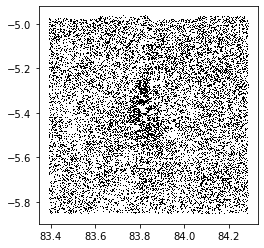

In [10]:
plt.plot(np.degrees(ds[q0]['mean']['RA']), np.degrees(ds[q0]['mean']['DEC']), 'k,')
plt.gca().set_aspect('equal')

[]

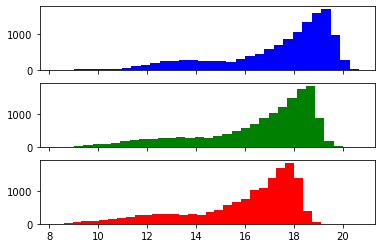

In [18]:
fig, axes = plt.subplots(nrows=3, sharex=True)

axes[0].hist(ds[q0]['median']['JAPERMAG3'], bins=30, color='b')
axes[1].hist(ds[q0]['median']['HAPERMAG3'], bins=30, color='g')
axes[2].hist(ds[q0]['median']['KAPERMAG3'], bins=30, color='r')

[]


## Next steps: can we reproduce the number of Q=1 and Q=2 stars?

There are 
- Q2 stars:
 - 2348
- Q1 + Q2 stars:
 - 3592

in the old "official_star_counter".


In [32]:
print(len(autocan_true.SOURCEID))
print(len(ds[q1_old & q1_location]))

# This is how you figure out the members of one set that are not members of the other set
print(np.sum(~np.in1d(ds[q1_old & q1_location].index, autocan_true.SOURCEID)))

new_sourceids = ds[q1_old & q1_location].index[~np.in1d(ds[q1_old & q1_location].index, autocan_true.SOURCEID)]

print(new_sourceids)

old_sourceids = autocan_true.SOURCEID[~np.in1d(autocan_true.SOURCEID, ds[q1_old & q1_location].index)]

print(old_sourceids)

3592
3592
0
Int64Index([], dtype='int64', name='SOURCEID')
[]


# Everything below this is out of date.
### Below here, I was investigating a mismatch between the new and old Q=1 lists, to identify (for example) a specific star that was not picked up by the old code but was picked up by an intermediate form of the new code.

In [29]:
# The photometry data lives here...

filename = "/Users/tsrice/Documents/Variability_Project_2020/wuvars/Data/copied_from_old_projects/WSERV5_fdece_graded_clipped0.8_scrubbed0.1_dusted0.5.fits"

dat = Table.read(filename)
df = dat.to_pandas()


In [30]:
pd.set_option('display.max_rows', 30)
first_new_source_photometry = df[df['SOURCEID'] == new_sourceids[0]]

first_new_source_photometry.head(30)

,SOURCEID,MEANMJDOBS,RA,DEC,JMHPNT,JMHPNTERR,HMKPNT,HMKPNTERR,JAPERMAG3,JAPERMAG3ERR,...,KAPERMAG3,KAPERMAG3ERR,JPPERRBITS,HPPERRBITS,KPPERRBITS,MERGEDCLASS,PSTAR,JGRADE,HGRADE,KGRADE
63754,44199508452068,54035.509907,1.456611,-0.090164,1.428383e+00,3.870209e-02,6.125517e-01,2.936747e-02,1.738188e+01,3.638512e-02,...,1.534095e+01,2.623877e-02,0,0,0,1,0.000171,0.993506,0.995671,0.975708
63755,44199508452068,54038.515527,1.456612,-0.090164,1.318002e+00,5.067773e-02,7.027760e-01,4.998946e-02,1.731064e+01,4.347483e-02,...,-9.999995e+08,4.267053e-02,0,0,0,1,0.008563,0.987179,0.877729,0.722449
63756,44199508452068,54039.485103,1.456611,-0.090164,1.420135e+00,4.135248e-02,6.936989e-01,2.968797e-02,1.737484e+01,3.854121e-02,...,1.526101e+01,2.562756e-02,0,0,0,1,0.000171,0.993548,0.991379,0.983806
63757,44199508452068,54040.524950,1.456611,-0.090164,1.392160e+00,4.426192e-02,6.685686e-01,3.165201e-02,1.732901e+01,4.059184e-02,...,1.526828e+01,2.627601e-02,0,0,0,1,0.000171,0.993548,0.991304,0.991903
63758,44199508452068,54048.451470,1.456611,-0.090164,1.459057e+00,4.600807e-02,7.029381e-01,3.257235e-02,1.739048e+01,4.203394e-02,...,1.522849e+01,2.666585e-02,0,0,0,1,0.052478,0.987179,0.927350,0.963115
63759,44199508452068,54050.514833,1.456611,-0.090164,2.248787e+00,7.449379e-02,6.796741e-01,3.091948e-02,1.819641e+01,7.260188e-02,...,1.526795e+01,2.603312e-02,64,0,0,1,0.002915,0.987179,0.991379,0.983806
63760,44199508452068,54051.564947,1.456612,-0.090164,1.371737e+00,4.737224e-02,6.586199e-01,3.396317e-02,1.733462e+01,4.339329e-02,...,1.530426e+01,2.814863e-02,0,0,0,1,0.052478,1.000000,0.961538,0.940239
63761,44199508452068,54052.553650,1.456612,-0.090164,-9.999995e+08,1.040192e+09,6.518641e-01,2.958322e-02,-9.999995e+08,1.040192e+09,...,1.528217e+01,2.557128e-02,0,0,0,1,0.003067,0.775362,0.983051,0.983673
63762,44199508452068,54053.529680,1.456611,-0.090164,1.282312e+00,4.253028e-02,6.917877e-01,3.169791e-02,1.726535e+01,3.848700e-02,...,1.529125e+01,2.602271e-02,0,0,0,1,0.000171,0.993590,0.933921,0.979592
63763,44199508452068,54054.558160,1.456611,-0.090164,-9.999995e+08,1.040192e+09,6.871233e-01,2.885057e-02,-9.999995e+08,1.040192e+09,...,1.530123e+01,2.563252e-02,0,0,0,1,0.003067,0.000000,0.995708,0.991870
